In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
def build_gan(z_dimension):
    
    gen_input = layers.Input(shape=(z_dimension,))

    y = layers.Dense(126, activation='relu')(gen_input)
    y = layers.Dense(126, activation='relu')(y)
    y = layers.Dense(8*8*3, activation="relu")(y)
    y = layers.Reshape((8,8,3))(y)

    y = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(y)
    y = layers.LeakyReLU()(y)
    y = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(y)
    y = layers.LeakyReLU()(y)
    y = layers.Conv2DTranspose(3, 3, strides=2, padding="same")(y)
    y = layers.Activation('sigmoid')(y)

    generator = models.Model(gen_input, y, name ='generator')
    
    disc_input = layers.Input(shape=(64,64,3))
    y = layers.Conv2D(32, 3, strides=2, padding="same")(disc_input)
    y = layers.LeakyReLU()(y)
    y = layers.Conv2D(32, 3, strides=2, padding="same")(y)
    y = layers.LeakyReLU()(y)
    y = layers.Conv2D(32, 3, strides=2, padding="same")(y)
    y = layers.LeakyReLU()(y)
 
    y = layers.Flatten()(y)
    y = layers.Dense(126, activation='relu')(y)
    y = layers.Dense(32, activation='relu')(y)
    y = layers.Dense(1, activation='sigmoid')(y)
    discriminator = models.Model(disc_input, y, name ='discriminator')
    
    gan = models.Sequential([generator, discriminator])
    return generator, discriminator, gan

In [3]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        real_output = discriminator(images, training=True)
        
        gene_loss = generator_loss(fake_output)
        gene_gradients = gen_tape.gradient(gene_loss, generator.trainable_variables)
    
        disc_loss = discriminator_loss(real_output, fake_output)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        gene_optimizer.apply_gradients(zip(gene_gradients, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    
    

In [4]:
def generate_and_save_images(model, epoch, test_input):
  
    predictions = model(test_input, training=False)
    print(predictions.shape)
    fig = plt.figure(figsize=(6,6))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.show()

In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gene_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)
gene_loss = tf.keras.metrics.Mean(name='gene_loss')
disc_loss = tf.keras.metrics.Mean(name='disc_loss')

(16, 64, 64, 3)


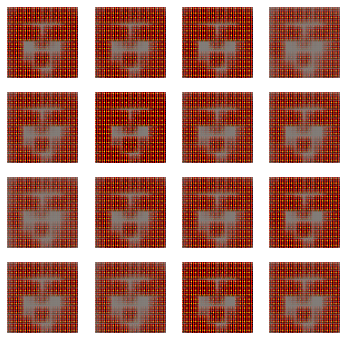

49 <tensorflow.python.keras.metrics.Mean object at 0x7f98d04f7610> <tensorflow.python.keras.metrics.Mean object at 0x7f98f0400b90>


In [6]:
epochs = 50
batch_size = 128
noise_dim = 100

generator, discriminator, gan = build_gan(noise_dim)

x_data = np.load('../0-Data/celeba/size64_v1/x_data.npy')
x_data = x_data[:10000]/255
dataset = tf.data.Dataset.from_tensor_slices(x_data).batch(batch_size)

seed = tf.random.normal([16, noise_dim])

for epoch in range(epochs):
        
        for image_batch in dataset:
            train_step(image_batch)
            
        # GIF를 위한 이미지를 바로 생성합니다.
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        print(epoch, gene_loss, disc_loss)